In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import lightgbm as lgb
from utils.utils import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

{'boosting_type': 'dart', 'learning_rate': 0.5, 'max_depth': 6, 'objective': 'l2'} 0.8041910801680963


Found `n_estimators` in params. Will use it instead of argument


The mean squared error (MSE) on train set: 1729923.3593
The mean squared error (MSE) on test set: 4369652309.7133
The mean squared error (MAPE) on train set: 0.1009
The mean squared error (MAPE) on test set: 0.8680
The R2 score (R2) on train set: 0.9998
The R2 score (R2) on test set: 0.6983


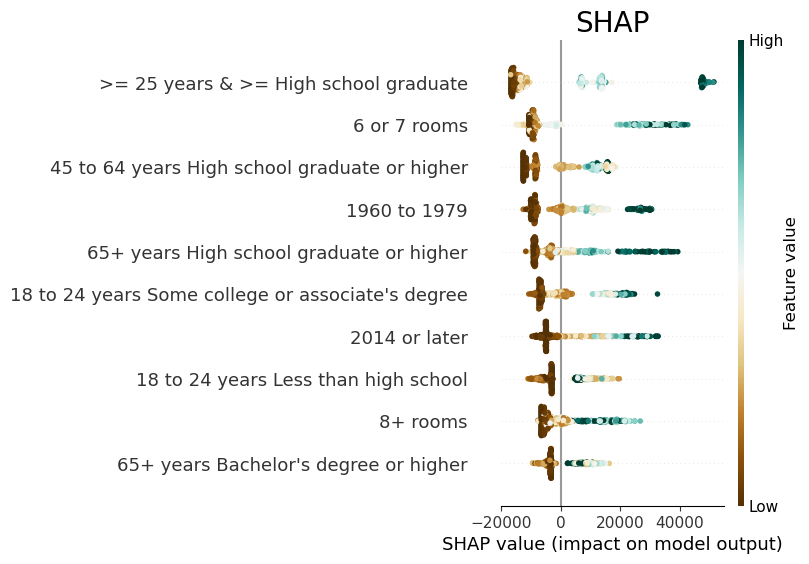

In [2]:
prep_data = prepare_data('201904')

X_train, y_train, X_test, y_test, X = get_train_test_data(prep_data, ['income', 'education', 'building', 'time_mode'])
train_data = lgb.Dataset(data = X_train, label = y_train, params={"max_bin":10,})
test_data = lgb.Dataset(data = X_test, label = y_test, reference=train_data)

param_grid = {
    'objective': ['l1', 'l2'],
    'max_depth': [5,6,7,8,9,10,15,20],
    'learning_rate': [0.5,0.6,0.7,0.8,0.9,1.0],
    'boosting_type': ['dart', 'gbdt']
    }

gkf = KFold(n_splits=2, shuffle=True, random_state=42).split(X=X_train, y=y_train)
lgb_estimator = lgb.LGBMRegressor(metric='mse', verbose=-1)
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
lgb_model = gsearch.fit(X=X_train, y=y_train)

print(lgb_model.best_params_, lgb_model.best_score_)

param = {'objective': lgb_model.best_params_['objective'], 
         'boosting_type': lgb_model.best_params_['boosting_type'], 
         'n_estimators': 1000, 
         'max_depth': lgb_model.best_params_['max_depth'],
         'metric': 'mape',
         'learning_rate':lgb_model.best_params_['learning_rate'],
         'verbose': -1}

reg = lgb.train(param, train_set=train_data)

print_metrics(reg, X_train, y_train, X_test, y_test)
plot_accuracy_scatter(reg, X_train, y_train, X_test, y_test, log_scale=True, size=6)
shap_analysis(reg, X, X_train, X_test)

{'boosting_type': 'dart', 'learning_rate': 0.5, 'max_depth': 6, 'objective': 'l2'} 0.8121844007819505


j:\PhD\Projects\chicago-energy-cons_bad\env\lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



The mean squared error (MSE) on train set: 2201823.0087
The mean squared error (MSE) on test set: 5060655490.5645
The mean squared error (MAPE) on train set: 0.1054
The mean squared error (MAPE) on test set: 0.8013
The R2 score (R2) on train set: 0.9998
The R2 score (R2) on test set: 0.7101


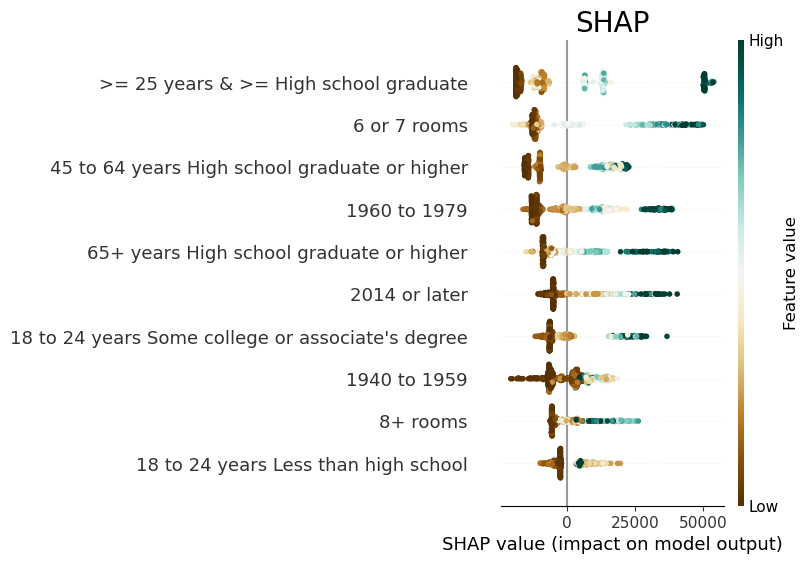

In [3]:
prep_data = prepare_data('202004')

X_train, y_train, X_test, y_test, X = get_train_test_data(prep_data, ['income', 'education', 'building', 'time_mode'])
train_data = lgb.Dataset(data = X_train, label = y_train, params={"max_bin":10,})
test_data = lgb.Dataset(data = X_test, label = y_test, reference=train_data)

param_grid = {
    'objective': ['l1', 'l2'],
    'max_depth': [5,6,7,8,9,10,15,20],
    'learning_rate': [0.5,0.6,0.7,0.8,0.9,1.0],
    'boosting_type': ['dart', 'gbdt']
    }

gkf = KFold(n_splits=2, shuffle=True, random_state=42).split(X=X_train, y=y_train)
lgb_estimator = lgb.LGBMRegressor(metric='mse', verbose=-1)
gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
lgb_model = gsearch.fit(X=X_train, y=y_train)

print(lgb_model.best_params_, lgb_model.best_score_)

param = {'objective': lgb_model.best_params_['objective'], 
         'boosting_type': lgb_model.best_params_['boosting_type'], 
         'n_estimators': 1000, 
         'max_depth': lgb_model.best_params_['max_depth'],
         'metric': 'mape',
         'learning_rate':lgb_model.best_params_['learning_rate'],
         'verbose': -1}

reg = lgb.train(param, train_set=train_data)

print_metrics(reg, X_train, y_train, X_test, y_test)
plot_accuracy_scatter(reg, X_train, y_train, X_test, y_test, log_scale=True, size=6)
shap_analysis(reg, X, X_train, X_test)